# sequana_coverage test case example (Bacteria Staphylococcus aureus)

This notebook uses as input the BED file provided in 

- https://github.com/sequana/resources/tree/master/coverage and

It shows that a constant threshold is not appropriate for bacterial genome where replication implies non-constant trend in the genome coverage. Then, it shows why a running median should be used instead of rolling average.

Versions used:
- sequana 0.6.4


In [5]:
%pylab inline
matplotlib.rcParams['figure.figsize'] = [10,7]

Populating the interactive namespace from numpy and matplotlib


# Sequana coverage (library)

In [2]:
from sequana import GenomeCov
b = GenomeCov("FN433596.bed")

In [3]:
# load the first chromosome and compute running median and get z-scores
chromosome = b.chr_list[0]
chromosome.run(30001, circular=True)

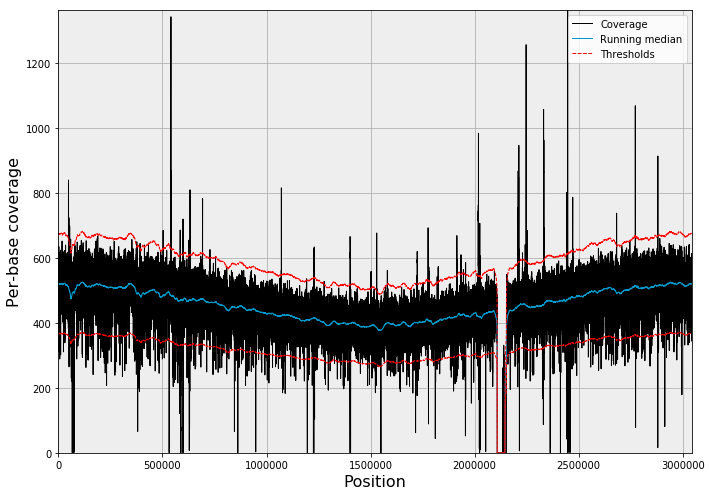

In [6]:
chromosome.plot_coverage()

Let us focus on the first 1Mb and plot the detected ROIs

(0, 850)

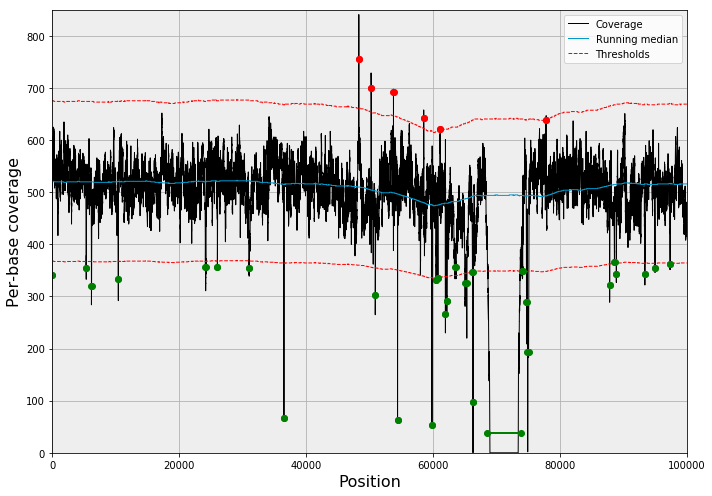

In [10]:
chromosome.plot_rois(0,100000)
ylim([0,850])

# What about a constant threshold ?

Here, we hack the library to set the zscore values to 0 everywhere execpt above and below 600 and 400 respectively. When calling get_rois() method, 
it re-filter the data to extract the features and perform the clustering
based on the zscore.

In [11]:
chromosome.df['zscore'] *= 0
chromosome.df.loc[chromosome.df['cov']>600, 'zscore'] = 5
chromosome.df.loc[chromosome.df['cov']<400, 'zscore'] = -5

In [12]:
rois = chromosome.get_rois()

In [13]:
# we've got lots of ROIs here. This of course depends on the thresholds
# fixed in the step above
len(rois)

24177

Here, we plot the coverage again; We can ignore the dashed lines (running median thresholds); instead we plot the horizontal lines at 400 and 600 and
the different detection. This is not too bas as compared to the plot above

In [15]:
x1 = 0
x2 = 100000
def plot_rois(x1,x2):
    chromosome.plot_coverage(x1=x1, x2=x2)
    high = rois.get_high_rois().query("end>@x1 and start<@x2")
    low = rois.get_low_rois().query("end>@x1 and start<@x2")
    for start, end, cov in zip(high.start, high.end, high.mean_cov):
        plot([start, end], [cov, cov], lw=2, color="r", marker="o")
    for start, end, cov in zip(low.start, low.end, low.mean_cov):
        plot([start, end], [cov, cov], lw=2, color="g", marker="o")
    ylim([0,850])    
    axhline(600, lw=3)
    axhline(400, lw=3)

In [19]:
std(chromosome.df['cov'])

84.115084841408134

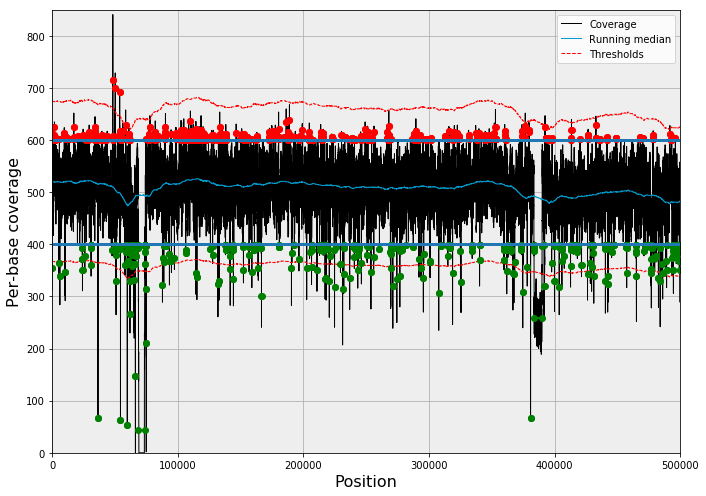

In [16]:
plot_rois(0,500000)

Keeping the same constant threshold, and looking at another part of the genome, there is a clear offset and this would not be correct
to use a constant threshold

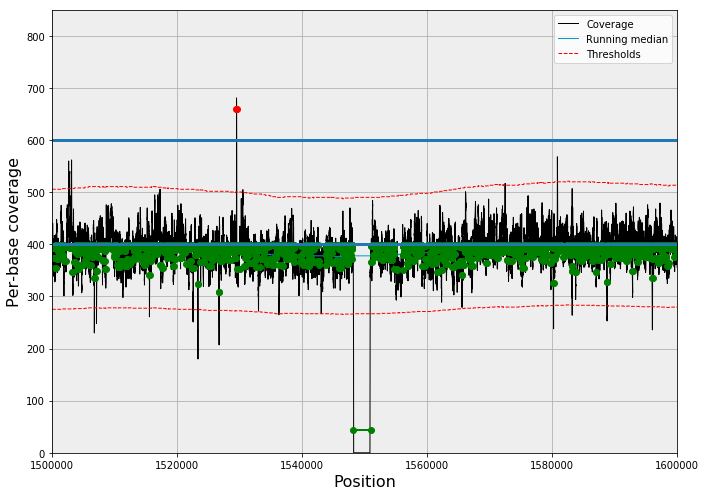

In [20]:
plot_rois(1500000,1600000)

**conclusion1: we need an adaptative threshold**

What about a rolling mean ? Why not but what would happen with CNVs, deleted regions, large outliers ? 
A running median is known to insensitive to outliers. 

Let us inject 2 events for the illustration 

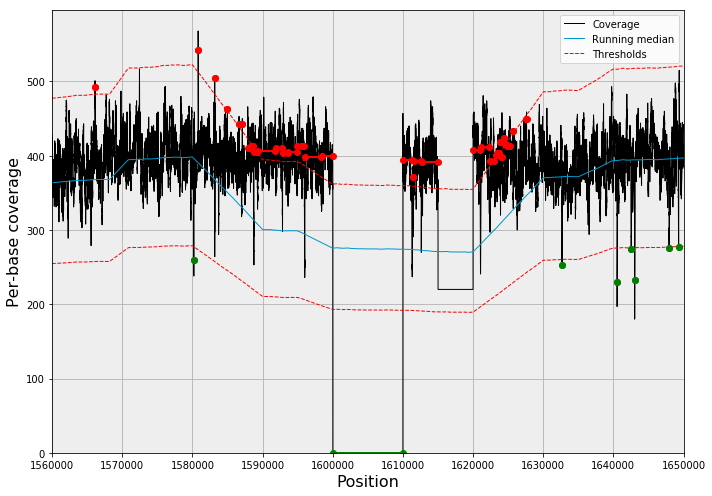

In [28]:
from sequana import GenomeCov
b = GenomeCov("FN433596.bed")
c = b.chr_list[0]
# We injecte a deleted region of 15000 bases
c.df.loc[1600000:1610000, "cov"] *= 0
# and a region of 220 depth of coverage (hald the mean depth of coverage) closeby (5000 bases apart)
c.df.loc[1615000:1620000, "cov"] = 220

# here is a hack where we compute the median just to create the data structure 
c.running_median(40001, circular=True)
# and replace it with the moving average
c.moving_average(40001, circular=True)
c.df['rm'] = c.df['ma']

c.compute_zscore()
c.plot_rois(1560000, 1650000)



what we see here is that the injected deleted event is detected (possition 1600000 to 1615000).
However, the next event with coverage of 220 is missed !
Besides, we have lots of false detection (red dots), in particular the region between the deleted region, and the depleted region
is considered as a region of interest of 5000 bases ! 

So, what would happen with a running median:
    

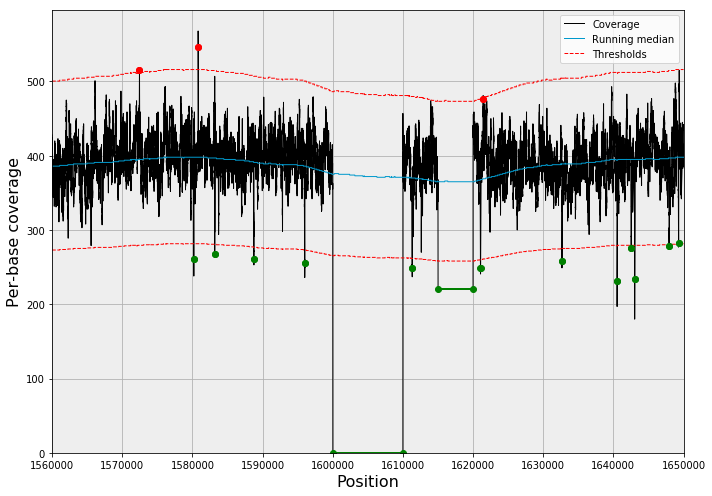

In [29]:
c.running_median(40001, circular=True)
c.compute_zscore()
c.plot_rois(1560000, 1650000)

**Conclusion2: a median estimator is more robust than the moving average**